

# AMLS Assignment
## Task B_3: CNN Tune on BloodMNIST Dataset

Explore CNN based classifiers on the BloodMNIST dataset.

## Import libraries
The required libraries for this notebook are sklearn, tensorflow, numpy and matplotlib.

In [57]:
## first enable autoreload during development so latest (new) version local code library is reloaded on execution 
## can be commented out when local code development not happening to avoid overhead
%load_ext autoreload
%autoreload 2

## import libraries
import io
import numpy as np
import matplotlib.pyplot as plt
        
## import tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, Hinge

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## local code library
import AMLS_common as ac

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set base parameters
Including hyperparameters and environment specifics

In [58]:
## Initialize hyperparameters
filename = "param_2025_01_14_at_153645.xlsx"
if os.path.isfile(filename):
    item = ac.HyperParameters.load_excel(filename)
else:
    print(filename+" does not exist. Loading default hyperparameters instead")
    item      = ac.HyperParameters(learning_rate=0.01, 
                                   kernel_size=3, 
                                   num_epochs=20, 
                                   num_filter=128,
                                   layers=4,
                                   dropout_rate=0.25,
                                   optimise="Adam",
                                   strides=2,
                                   padding="same",
                                   loss="sparse_categorical_crossentropy")
print(ac.HyperParameters.list_parameters(item))

tqdm_callback = ac.TqdmEpochProgress(total_epochs=item.num_epochs)

learning_rate: 0.01
kernel_size: 3
num_epochs: 20
optimise: Adam
loss: sparse_categorical_crossentropy
num_filter: 128
strides: 2
padding: same
dropout_rate: 0.25
layers: 4
default_activation: relu



In [59]:
## control (e.g. verbose) parameters
batch_size = 128
filebase   = "metrics/"          ## place to save output files
verbose    = 1                   ## to control whether additional in process information is printed

## Load and preprocess the BloodMNIST Data
We load the dataset.

In [60]:
## Loading the data file using common MedMINST loader
data_flag  = 'bloodmnist'        # defines which dataset to load
result_set = ac.medMNIST_load(data_flag,batch_size)

## check that the loader returned data correctly and then split out
if result_set != []:
    train_dataset = result_set[0]
    test_dataset  = result_set[1]
    val_dataset   = result_set[2]

if verbose == 1:
    ## print summary stats for training dataset
    print("\nSummary metrics for train_dataset")
    print("type:",type(train_dataset))
    print("length:",len(train_dataset))
    print("shape:",train_dataset)

Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\johnc\.medmnist\bloodmnist.npz

Summary metrics for train_dataset
type: <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
length: 94
shape: <BatchDataset shapes: ((None, 28, 28, 3), (None, 1)), types: (tf.float64, tf.float32)>


## Define the CNN model

Define a base model

In [61]:
## Define the model
if verbose == 1:
    print("Default activation is ",item.default_activation)

if item.layers == 3:
        model = Sequential([
            Conv2D(item.num_filter*4, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation,\
                   input_shape=(28, 28, 3)),                                             ## Input layer with larger num filter
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Second part of convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Dropout(item.dropout_rate),                                                  ## Initial dropout to reduce overfitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Another convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Flatten(),                                                                   ## Flatten
            Dense(item.num_filter*8,activation=item.default_activation),
            Dropout(item.dropout_rate*2),                                                ## Added larger dropout to reduce overfitting
            Dense(8, activation='softmax')                                               ## Output layer for 8 types 
        ])
    
if item.layers == 4:
        model = Sequential([
            Conv2D(item.num_filter*4, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation,\
                   input_shape=(28, 28, 3)),                                             ## Input layer with larger num filter
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Second part of convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Dropout(item.dropout_rate),                                                  ## Initial dropout to reduce overfitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Another convolution layer 
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## With added convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Flatten(),                                                                   ## Flatten
            Dense(item.num_filter,activation=item.default_activation),
            Dropout(item.dropout_rate*2),                                                ## Added larger dropout to reduce overfitting
            Dense(8, activation='softmax')                                               ## Output layer for 8 types 
        ])

if item.layers == 5:
        model = Sequential([
            Conv2D(item.num_filter*4, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation,\
                   input_shape=(28, 28, 3)),                                             ## Input layer with larger num filter
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Second part of convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Dropout(item.dropout_rate),                                                  ## Initial dropout to reduce overfitting
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Another convolution layer 
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## With added convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Again reduce the features
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## Another convolution layer 
            Conv2D(item.num_filter, kernel_size=item.kernel_size,\
                   padding=item.padding,activation=item.default_activation),             ## With added convolution layer 
            MaxPooling2D((2, 2),strides=item.strides),                                   ## Combined with pooling
            Flatten(),                                                                   ## Flatten
            Dense(item.num_filter*8,activation=item.default_activation),
            Dropout(item.dropout_rate*2),                                                ## Added larger dropout to reduce overfitting
            Dense(8, activation='softmax')                                               ## Output layer for 8 types 
        ])
        
print(model.summary())
## Redirect the summary output to a string
summary_string = io.StringIO()
model.summary(print_fn=lambda x: summary_string.write(x + "\n"))
summary_content = summary_string.getvalue()
summary_string.close()

optimizer_choice = str(item.optimise)+'(learning_rate='+str(item.learning_rate)+')'
optimizer        = eval(optimizer_choice)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),                                                   
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics='acc')

Default activation is  relu
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 512)       14336     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 128)       589952    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooli

## Fit the model

Fit using hyperparameters as defined above

Epoch Progress: 100%|██████████| 20/20 [1:58:05<00:00, 354.27s/epoch, loss=0.263, acc=0.906, val_loss=0.293, val_acc=0.909]


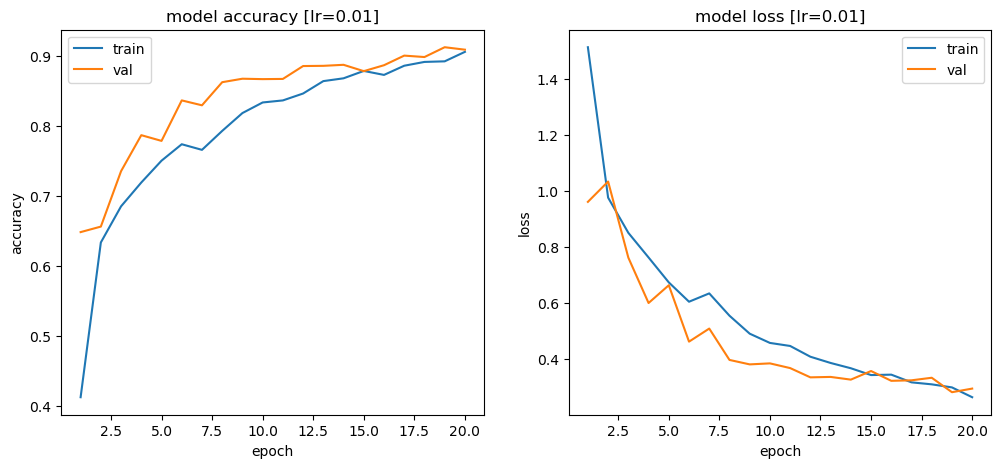

for model
 Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 512)       14336     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 128)       589952    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 1

['metrics/metrics_2025_01_16_at_130031.xlsx',
 'metrics/summary_2025_01_16_at_130031.txt',
 RunResult(min_loss=0.2625961899757385, max_acc=0.9062630534172058, last_loss=0.2625961899757385, last_acc=0.9062630534172058, min_val_loss=0.2805391550064087, max_val_acc=0.9128909707069397, last_val_loss=0.2934558391571045, last_val_acc=0.909383237361908, var_loss=0.09064024377250204, var_acc=0.013821119111207272),
 HyperParameters(learning_rate=0.01, kernel_size=3, num_epochs=20, optimise='Adam', loss='sparse_categorical_crossentropy', num_filter=128, strides=2, padding='same', dropout_rate=0.25, layers=4, default_activation='relu')]

In [62]:
## Fit the model

history = model.fit(train_dataset, 
                    validation_data=test_dataset, 
                    epochs=item.num_epochs, 
                    batch_size=batch_size, 
                    verbose=0,
                    callbacks = [tqdm_callback])

## output graphs and save metrics files
ac.graph_and_save(history,summary_content,item,filebase)

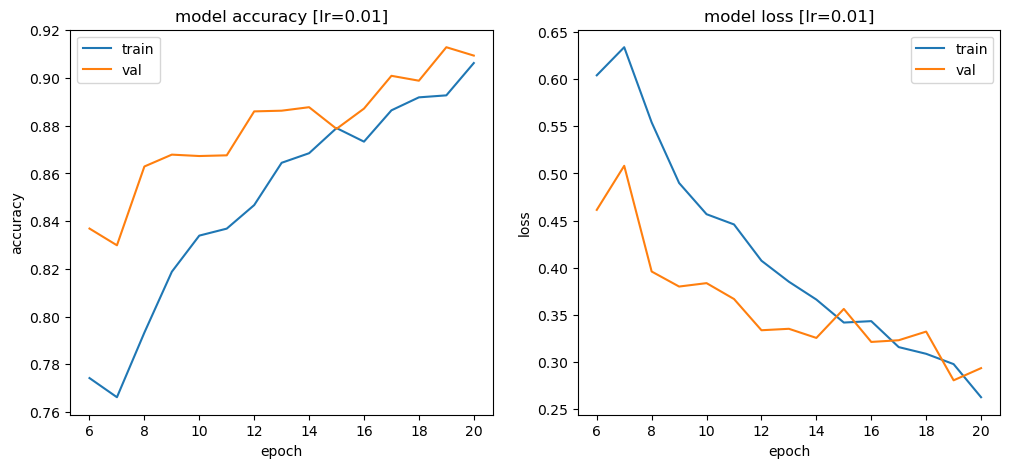

for model
 Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 28, 28, 512)       14336     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 28, 28, 128)       589952    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 7, 7, 1

In [63]:
ac.graph(history,summary_content,item,skip=5)

Confusion Matrix:

Run with HyperParameters(learning_rate=0.01, kernel_size=3, num_epochs=20, optimise='Adam', loss='sparse_categorical_crossentropy', num_filter=128, strides=2, padding='same', dropout_rate=0.25, layers=4, default_activation='relu')


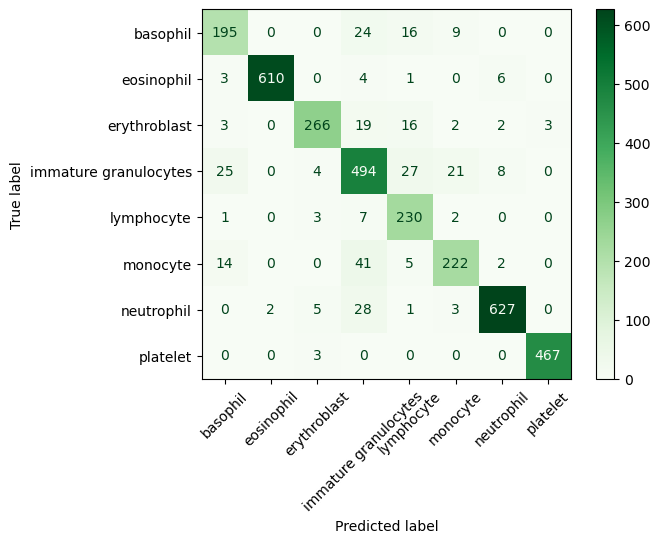

In [64]:
    labels         = ["basophil","eosinophil","erythroblast","immature granulocytes",\
                      "lymphocyte","monocyte","neutrophil","platelet"]
    x_test, y_test = ac.dataset_to_numpy(test_dataset)
    prediction     = model.predict(x_test)
    ## Convert one-hot to integer labels
    prediction     = np.argmax(prediction, axis=1)
    conf_matrix    = confusion_matrix(y_test, prediction)
    print("Confusion Matrix:\n")
    print("Run with",item)
    disp           = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,display_labels = labels)
    disp.plot(cmap='Greens')
    plt.xticks(rotation=45)  ## Rotate x-axis labels by 45 degrees to help readability
    plt.show()
    print("\n")